In [1]:
# Core
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Step 0: Upload and unzip dataset.zip

from zipfile import ZipFile
import os

# If running in Colab, first upload the zip
from google.colab import files

uploaded = files.upload()  # Upload your dataset.zip here

# Extract the ZIP file
zip_file_name = "dataset.zip"  # Make sure this matches your uploaded file name

with ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall("data")  # Extract contents to 'data/' directory

# List extracted files
os.listdir("data")


Saving dataset.zip to dataset.zip


['data']

In [12]:
import pandas as pd
import os

# Path where your .pkl files are stored
folder_path = "/content/data/data"

# List all .pkl files
pkl_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.pkl')])

# Combine all into a single dataframe
df_list = []
for file in pkl_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_pickle(file_path)
    df_list.append(df)

# Final combined dataframe
df = pd.concat(df_list, ignore_index=True)

# Preview
df.head()


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0


Dataset shape: (1754155, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754155 entries, 0 to 1754154
Data columns (total 9 columns):
 #   Column             Dtype         
---  ------             -----         
 0   TRANSACTION_ID     int64         
 1   TX_DATETIME        datetime64[ns]
 2   CUSTOMER_ID        object        
 3   TERMINAL_ID        object        
 4   TX_AMOUNT          float64       
 5   TX_TIME_SECONDS    object        
 6   TX_TIME_DAYS       object        
 7   TX_FRAUD           int64         
 8   TX_FRAUD_SCENARIO  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 120.4+ MB

Missing values:
 TRANSACTION_ID       0
TX_DATETIME          0
CUSTOMER_ID          0
TERMINAL_ID          0
TX_AMOUNT            0
TX_TIME_SECONDS      0
TX_TIME_DAYS         0
TX_FRAUD             0
TX_FRAUD_SCENARIO    0
dtype: int64


<Axes: title={'center': 'Fraud vs Legitimate'}, xlabel='TX_FRAUD', ylabel='Count'>

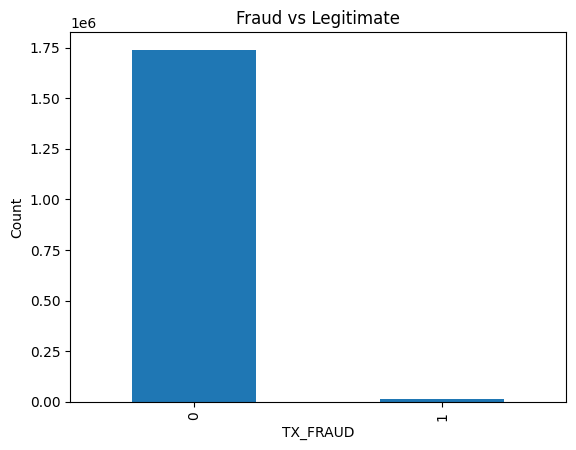

In [13]:
# Check shape and column types
print("Dataset shape:", df.shape)
df.info()

# Check for missing values
print("\nMissing values:\n", df.isnull().sum())

# Check target class distribution
df['TX_FRAUD'].value_counts().plot(kind='bar', title='Fraud vs Legitimate', xlabel='TX_FRAUD', ylabel='Count')


In [14]:
# Convert TX_TIME_SECONDS and TX_TIME_DAYS to integers
df['TX_TIME_SECONDS'] = pd.to_numeric(df['TX_TIME_SECONDS'], errors='coerce')
df['TX_TIME_DAYS'] = pd.to_numeric(df['TX_TIME_DAYS'], errors='coerce')


In [15]:
# Step 4: Feature Engineering

# 1. Convert datetime column
df['TX_DATETIME'] = pd.to_datetime(df['TX_DATETIME'])

# 2. Convert TX_TIME_SECONDS and TX_TIME_DAYS from object to numeric
df['TX_TIME_SECONDS'] = pd.to_numeric(df['TX_TIME_SECONDS'], errors='coerce')
df['TX_TIME_DAYS'] = pd.to_numeric(df['TX_TIME_DAYS'], errors='coerce')

# 3. Extract additional temporal features from TX_DATETIME
df['TX_HOUR'] = df['TX_DATETIME'].dt.hour
df['TX_DAY'] = df['TX_DATETIME'].dt.day
df['TX_WEEKDAY'] = df['TX_DATETIME'].dt.weekday

# 4. Drop columns not needed for modeling
df.drop(columns=['TRANSACTION_ID', 'TX_DATETIME', 'TX_FRAUD_SCENARIO'], inplace=True)

# 5. Encode categorical IDs (CUSTOMER_ID and TERMINAL_ID)
df['CUSTOMER_ID'] = df['CUSTOMER_ID'].astype('category').cat.codes
df['TERMINAL_ID'] = df['TERMINAL_ID'].astype('category').cat.codes

# 6. Final feature check
df.head()


,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_HOUR,TX_DAY,TX_WEEKDAY
0,595,3156,57.16,31,0,0,0,1,6
1,4951,3412,81.51,130,0,0,0,1,6
2,2,1365,146.00,476,0,0,0,1,6
3,4118,8737,64.49,569,0,0,0,1,6
4,926,9906,50.99,634,0,0,0,1,6


In [16]:
from sklearn.model_selection import train_test_split

X = df.drop('TX_FRAUD', axis=1)
y = df['TX_FRAUD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)


In [22]:
!pip install xgboost imbalanced-learn


In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (after scaling)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, stratify=y, random_state=42)

# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Check class balance
print("Before SMOTE:\n", y_train.value_counts())
print("After SMOTE:\n", y_train_bal.value_counts())


Before SMOTE:
 TX_FRAUD
0    1304605
1      11011
Name: count, dtype: int64
After SMOTE:
 TX_FRAUD
0    1304605
1    1304605
Name: count, dtype: int64


In [26]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_bal, y_train_bal)

# Get probabilities for threshold tuning
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]


In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.arange(0.0, 1.01, 0.05)
print(f"{'Threshold':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 40)

for t in thresholds:
    preds = (y_pred_proba >= t).astype(int)
    p = precision_score(y_test, preds, zero_division=0)
    r = recall_score(y_test, preds, zero_division=0)
    f1 = f1_score(y_test, preds, zero_division=0)
    print(f"{t:<10.2f} {p:<10.2f} {r:<10.2f} {f1:<10.2f}")


Threshold  Precision  Recall     F1-Score  
----------------------------------------
0.00       0.01       1.00       0.02      
0.05       0.01       0.90       0.02      
0.10       0.01       0.64       0.02      
0.15       0.02       0.38       0.05      
0.20       0.07       0.28       0.11      
0.25       0.17       0.25       0.20      
0.30       0.30       0.24       0.27      
0.35       0.43       0.24       0.31      
0.40       0.56       0.23       0.33      
0.45       0.66       0.23       0.34      
0.50       0.73       0.23       0.35      
0.55       0.77       0.23       0.35      
0.60       0.82       0.23       0.36      
0.65       0.85       0.23       0.36      
0.70       0.89       0.23       0.36      
0.75       0.92       0.23       0.36      
0.80       0.95       0.22       0.36      
0.85       0.98       0.22       0.36      
0.90       1.00       0.22       0.36      
0.95       1.00       0.22       0.36      
1.00       0.00       0.00       0.

Accuracy: 0.9910110617299716

Classification Report (Threshold = 0.35):
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    434869
           1       0.43      0.24      0.31      3670

    accuracy                           0.99    438539
   macro avg       0.71      0.62      0.65    438539
weighted avg       0.99      0.99      0.99    438539



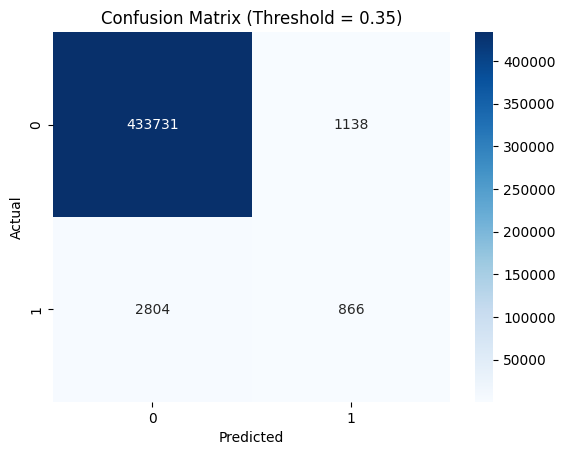

ROC AUC Score: 0.6757


In [32]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Choose a threshold (after printing test table, pick best tradeoff)
threshold = 0.35  # <--- 🔁 Change this value based on your test results
y_pred_thresh = (y_pred_proba >= threshold).astype(int)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_thresh))
print("\nClassification Report (Threshold = 0.35):\n", classification_report(y_test, y_pred_thresh))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_thresh), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Threshold = {threshold})")
plt.show()

# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")


In [33]:
import joblib

joblib.dump(xgb_model, "fraud_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']